# Just-in-Time (JIT) compilation
**Python for HPC course**

Max Planck Computing and Data Facility, Garching

## Just-in-Time (JIT) compilation
* just-in-time compilation refers to the compilation of a program or parts of it at *runtime* when the datatypes of variables (parameters, arrays) and their attributes (size of arrays) are known
    * initial overhead due to compilation
    * subsequent calls use compiled code from a cache
* `java` or `julia`, e.g., are languages that natively make use of JITing
* for Python JITing is available through packages such as `Numba`, `jax`, `numexpr`

## Numba
* Numba is a Just-in-Time (JIT) Compiler for Python code
* designed to accelerate numerical computation implemented in NumPy
* convenient usage via decorators (`@jit`), not a separate language like Cython  
  $\to$ keeps Python code compatibility
* built on the LLVM compiler backend, support for
    * CPUs
    * GPUs (NVIDIA, AMD)
* https://numba.pydata.org/

### Codes which will (probably) benefit from Numba JIT

* numerical computation
* NumPy expressions
* explicit loops

... on sufficiently large data

### Codes which likely won't

* calls to packages beyond plain Python and NumPy, Numba will just ignore code it does not know
* IO

[Credit for the examples discussed in the following:  
http://numba.pydata.org/numba-doc/latest/index.html ]

### Under the hood of Numba

When a `@jit`-decorated function is called for the first time, Numba will
1. read Python bytecode
2. consider information about the types of the input arguments
3. analyze and optimize code
4. generate a machine code version using LLVM

The compiled version is then used each time the function is called.  
$\to$ For performance benchmarks, one should exclude the first call.

### Numba on explicit loops

In [3]:
from numba import jit
import numpy as np

m = 1024
x = np.arange(m*m, dtype=np.float32).reshape(m, m)

def trace_add(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    b = a + trace
    return b
%timeit trace_add(x)

@jit(nopython=True)    # set "nopython" mode to make sure that the
def trace_jit(a):      # function is compiled completely when called the first time
    trace = 0.0
    for i in range(a.shape[0]):    # Numba supports explicit loops
        trace += np.tanh(a[i, i])  # Numba supports NumPy functions
    b = a + trace                  # Numba supports NumPy broadcasting
    return b
trace_jit(x)

%timeit trace_jit(x)

1.41 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
752 µs ± 4.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Numba's `nopython` mode

* the flag `nopython=True` instructs `@jit` to compile the decorated function  
  such that is runs entirely without the Python interpreter
* `@njit` is a convenience shorcut for `@jit(nopython=True)`
* compilation fails in case Python calls are necessary

### NumPy expressions
* Numba is able to compile "vectorized" NumPy expressions

In [4]:
import numpy as np
from numba import njit

@njit
def ident_numpy(x):
    return np.cos(x) ** 2 + np.sin(x) ** 2

@njit
def ident_loops(x):
    r = np.empty_like(x)
    n = len(x)
    for i in range(n):
        r[i] = np.cos(x[i]) ** 2 + np.sin(x[i]) ** 2
    return r

In [5]:
x = np.arange(2**20, dtype=np.float32)

%timeit ident_numpy(x)
%timeit ident_loops(x)

11.6 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.5 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba's `fastmath` mode

* `fastmath=True` enables compiler optimizations which *might* further speed up your code
* similar to well-known GCC ('-ffash-math') or Intel compiler flags ('-fp-model fast=2')
* potential to alter numerical results due to
    * non-deterministic summation order and roundoff errors,  
      to be expected e.g. for any parallel reduction (using vectorization, parallelization)
    * fast but less precise math functions (sqrt, log, ...)
* check you results carefully

In [6]:
import numpy as np
from numba import njit

@njit
def ident_slowmath(x):
    np.sum(np.log(np.exp(x)) ** 2)

@njit(fastmath=True)
def ident_fastmath(x):
    np.sum(np.log(np.exp(x)) ** 2)

In [7]:
x = np.ones(2**20, dtype=np.float32)

%timeit ident_slowmath(x)
%timeit ident_fastmath(x)

13.2 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
399 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Auto-parallelization with Numba

* auto-parallelization of NumPy expressions via multithreading
* explicit loop parallelization using `prange()` via multithreading
* number of threads
    * all available cores (default)
    * set via environment variable `NUMBA_NUM_THREADS`
    * set via `numba.set_num_threads()`
* available backends (selected automatically)
    * Numba-internal workqueue
    * Intel TBB
    * OpenMP

In [8]:
import numpy as np
from numba import njit, prange

@njit(parallel=False)
def ident_numpy_fm_seq(x):
    return np.cos(x) ** 2 + np.sin(x) ** 2

@njit(parallel=True)
def ident_numpy_fm_par(x):
    return np.cos(x) ** 2 + np.sin(x) ** 2

@njit(parallel=True)
def ident_loops_fm_par(x):
    r = np.empty_like(x)
    n = len(x)
    for i in prange(n):
        r[i] = np.cos(x[i]) ** 2 + np.sin(x[i]) ** 2
    return r

In [9]:
x = np.arange(2**20, dtype=np.float32)

%timeit ident_numpy_fm_seq(x)
%timeit ident_numpy_fm_par(x)
%timeit ident_loops_fm_par(x)

11.1 ms ± 66.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


5.37 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.19 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Advanced Numba features of potential interest

* `@vectorize`, generate NumPy `ufunc` objects
* `@stencil`, define stencil operations on NumPy arrays
* `@cuda`, target NVIDIA CUDA GPUs
* `@roc`, target AMD GPUs

Please see the documentation for further information.  
http://numba.pydata.org/numba-doc/latest/index.html

### Numba application
* let's continue with the `Diffusion.ipynb` notebook

## Jax
* jax is a library for numerical computing and machine learning
* jax provides a NumPy-like API which can be used as a drop-in replacement for original NumPy
* jax provides just-in-Time (JIT) compilation and automatic differentiation
* built on the [XLA](https://www.tensorflow.org/xla) compiler, support for
    * CPUs
    * GPUs (NVIDIA, AMD)
    * Google's TPUs
* https://jax.readthedocs.io/en/latest/

## Jax vs. Numba

* for the JIT interface, both provide a simple `jit` interface
* both use LLVM as the compiler backend; jax with a layer of indirection via the XLA compiler
* jax supports CPU/GPU/TPU backends with exactly the same codebase (e.g., no cuda knowledge necessary)
* jax excells when used on accelerator devices
* jax will fail on code it doesn't know
* jax provides automatic differentiation in addition
* jax is general purpose but many concepts have a background in machine learning (e.g. batch parallelization)

### JIT compilation with jax

In [10]:
from jax import jit
import jax.numpy as np

m = 1024
x = np.arange(m*m, dtype=np.float32).reshape(m, m)

@jit
def trace_add(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    b = a + trace
    return b
trace_add(x)

%timeit trace_add(x)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


646 µs ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Autodifferentiation with jax

In [ ]:
from jax import grad

def reduce_trace_add(a):
    """Reduction have scalar output."""
    return trace_add(a).sum()

grad_reduce_trace_add = jit(grad(reduce_trace_add))
grad_reduce_trace_add(x)

%timeit grad_reduce_trace_add(x)

### Features of jax

* jax also provides multivariate differentiation via `jacfwd`, `jacrev`, `jvp`, `vjp`
* jax has support for vectorization and parallelization: `vmap`, `pmap`
* jax is still under active development but becoming increasingly [popular](https://github.com/n2cholas/awesome-jax)

## Other JIT solutions

### NumExpr: Fast numerical expression evaluator for NumPy

* translates (nested) NumPy expressions into loop representation and compiles  
  $\rightarrow$ memory saving, cache blocking, thread parallelization, SIMD
* NumPy expressions must be passed as strings
* https://github.com/pydata/numexpr

### *pystencils*

* sympy-based code generator for **stencil computations on NumPy arrays**
* due to knowledge about the structure of the stencil, the code can be highly optimized
* https://i10git.cs.fau.de/pycodegen/pystencils

Optional exercise: implement the diffusion computations using these tools!

## backup material below -- not presented any more

### Exploring Numba's / LLVM's internals
#### Summation

In [12]:
%matplotlib inline

In [13]:
import numpy as np

timings = {}

def time_it(func, result_dict=timings, store_result=True):
    """Decorator to conveniently gather timing results."""
    def timed_call(*args, **kw):
        time = %timeit -o func(*args, **kw)
        name = func.__name__
        if store_result:
            result_dict[name] = np.average(time.timings)
        # need to call func once again to get the return value
        return_value = func(*args, **kw)
        return return_value
    return timed_call

In [14]:
@time_it
def count_python(n):
    j = 0
    for i in range(n):
        j += i
    return j

In [15]:
@time_it
def count_numpy(n):
    return np.sum(np.arange(n))

In [16]:
%load_ext Cython

In [17]:
%%cython -c=-O3 -c=-march=native
import numpy as np
cimport numpy as np
cimport cython

# time_it decorator does not work with cython
def c_count_cython(np.int64_t n):
    cdef np.int64_t i
    cdef np.int64_t j = 0
    for i in range(n):
        j += i
    return j

In file included from /opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/khr/.cache/ipython/cython/_cython_magic_5b181cbe33290ddc711ffcafb8e3728f.c:779:
/opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [18]:
@time_it
def count_cython(n):
    return c_count_cython(n)

In [19]:
from numba import jit

@jit(nopython=True)
def c_count_numba(n):
    j = 0
    for i in range(n):
        j += i
    return j

In [20]:
c_count_numba(1024)

@time_it
def count_numba(n):
    return c_count_numba(n)

In [21]:
N = 2**16

In [22]:
count_python(N)

3.45 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


2147450880

In [23]:
count_numpy(N)

48.2 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


2147450880

In [24]:
count_cython(N)

7.44 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


2147450880

In [25]:
count_numba(N)

307 ns ± 14.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


2147450880

In [26]:
@time_it
def count_analytic(n):
    return n*(n-1)//2

In [27]:
count_analytic(N)

220 ns ± 5.33 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


2147450880

In [28]:
# numba/llvm seems able to figure out the analytic solution!
# update 2023: this also seems to be the case for Cython on the Mac which uses an LLVM-based compiler

lvm = c_count_numba.inspect_llvm()
for k, v in lvm.items():
    print(v,k)

; ModuleID = 'c_count_numba'
source_filename = "<string>"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

@.const.c_count_numba = internal constant [14 x i8] c"c_count_numba\00"
@_ZN08NumbaEnv8__main__13c_count_numbaB3v26B38c8tJTIcFKzyF2ILShI4CrgQElQb6HczSBAA_3dEx = common local_unnamed_addr global i8* null
@".const.missing Environment: _ZN08NumbaEnv8__main__13c_count_numbaB3v26B38c8tJTIcFKzyF2ILShI4CrgQElQb6HczSBAA_3dEx" = internal constant [107 x i8] c"missing Environment: _ZN08NumbaEnv8__main__13c_count_numbaB3v26B38c8tJTIcFKzyF2ILShI4CrgQElQb6HczSBAA_3dEx\00"
@PyExc_RuntimeError = external global i8

; Function Attrs: nofree norecurse nosync nounwind writeonly
define i32 @_ZN8__main__13c_count_numbaB3v26B38c8tJTIcFKzyF2ILShI4CrgQElQb6HczSBAA_3dEx(i64* noalias nocapture writeonly %retptr, { i8*, i32, i8*, i8*, i32 }** noalias nocapture readnone %excinfo, i64 %arg.n) local_unnamed_addr #0 {
B0.en

#### Parallel summation

* parallelization hinders analytic optimization

In [29]:
from numba import prange, set_num_threads
set_num_threads(2)

In [30]:
@jit(nopython=True, parallel=True)
def c_numba_parallel(n):
    j = 0
    for i in prange(n):
        # implicit atomic update of j!
        j += i
    return j

In [31]:
c_numba_parallel(1024)

@time_it
def numba_parallel(n):
    return c_numba_parallel(n)

numba_parallel(N)

2.33 µs ± 29.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


2147450880

### Plot the timings and compare

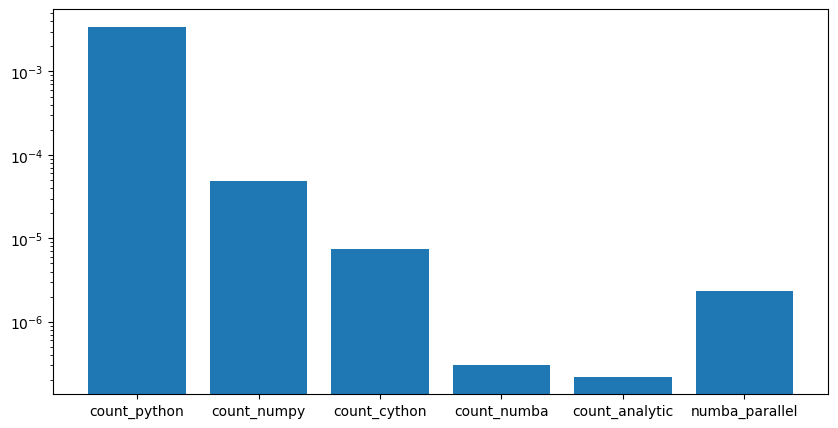

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
values = list(timings.values())
labels = list(timings.keys())
x = range(len(labels))
ax.set_yscale('log')
plt.bar(x, values, align='center')
_xtcs = plt.xticks(x, labels)

#### Sum over squared numbers

In [33]:
from numba import jit

@jit(nopython=True)
def _count_squared_numba(n):
    j = 0
    for i in range(n):
        j += i*i
    return j

def count_squared_numba(n):
    return _count_squared_numba(n)

In [34]:
%%timeit
count_squared_numba(N)

264 ns ± 3.66 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [35]:
def count_squared_analytic(n):
    m = n - 1  # exclude n, to use Gauss' well-known formula below
    return m * (m + 1) * (2 * m + 1) // 6

In [36]:
%%timeit
count_squared_analytic(N)

310 ns ± 3.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


#### Does Numba preserve Python semantics?
* Python implements infinite precision integers!

In [37]:
M = 2**63 - 1

In [38]:
count_analytic(M)

312 ns ± 4.11 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


42535295865117307919086767873688862721

In [39]:
# integer overflow
count_numba(M)

324 ns ± 5.01 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


4611686018427387905